In [ ]:
# 3.2 Team Comparison Analysis 
## Contributor: Anthony Mapuyan

In [ ]:
# Code to connect to the database and perform analysis
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway
import seaborn as sns

pd.set_option("display.max_rows", None)

load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT", "3306")
DB_NAME = os.getenv("DB_NAME")
DB_TABLE = os.getenv("DB_TABLE", "research_experiment_refractor_test")

connection_string = (
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

engine = create_engine(connection_string)

print("Database connection established successfully.")

df = pd.read_sql(text(f"SELECT * FROM {DB_TABLE}"), engine)
df.head()


selected_metrics = [
    "Jump Height(m)",
    "Peak Propulsive Force(N)",
    "Peak Velocity(m/s)",
    "Propulsive Net Impulse(N.s)",
    "mRSI",
]


Database connection established successfully.


In [6]:
# filter teams based on coverage of selected metrics
metrics_sql = ", ".join([f"'{m}'" for m in selected_metrics])

query_team_coverage = f"""
SELECT 
    team,
    COUNT(DISTINCT metric) AS num_metrics_found
FROM {DB_TABLE}
WHERE metric IN ({metrics_sql})
GROUP BY team
ORDER BY num_metrics_found DESC;
"""

team_coverage = pd.read_sql(text(query_team_coverage), engine)
team_coverage

,team,num_metrics_found
0,Team: Old Football,5
1,Team: Stony Brook Men's Soccer,5
2,"Team: Stony Brook Men's Basketball , Team: Men...",5
3,Team: Stony Brook Men's Basketball,5
4,"Team: Stony Brook Football, Team: Stony Brook",5
5,Team: Stony Brook Football,5
6,Team: Stony Brook Baseball,5
7,Team: Stony Brook,5
8,Team: SBU WLAX,5
9,Team: Stony Brook Men's T&F,5


In [17]:
import numpy as np
# Make sure timestamp is datetime just in case
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Create a cleaner team label based on substring patterns
df["team_clean"] = np.select(
    [
        df["team"].str.contains("Stony Brook Football", case=False, na=False),
        df["team"].str.contains("Men's Basketball", case=False, na=False),
    ],
    [
        "Stony Brook Football (Men)",
        "Stony Brook Men's Basketball",
    ],
    default="Other"
)

df["team_clean"].value_counts()

team_clean
Other                           5687439
Stony Brook Men's Basketball     483336
Stony Brook Football (Men)       446651
Name: count, dtype: int64

In [ ]:
# Select only the teams of interest
teams_of_interest = [
    "Stony Brook Football (Men)",
    "Stony Brook Men's Basketball",
]

df_teams = df[df["team_clean"].isin(teams_of_interest)].copy()
df_teams["team_clean"].value_counts()


team_clean
Stony Brook Men's Basketball    483336
Stony Brook Football (Men)      446651
Name: count, dtype: int64

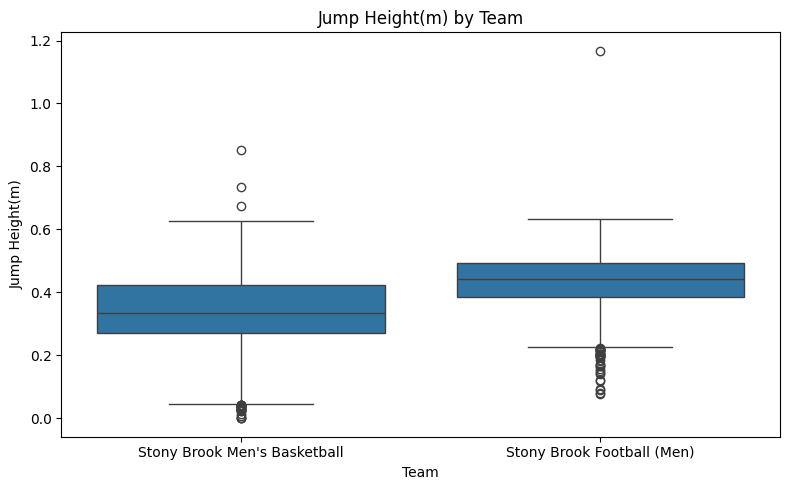

In [26]:
# Box Plot comparing Jump height
metric = "Jump Height(m)"

df_metric = df_teams[df_teams["metric"] == metric].copy()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_metric, x="team_clean", y="value")
plt.title(f"{metric} by Team")
plt.xlabel("Team")
plt.ylabel(metric)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
# Statistical significance (t-test)
group_a = df_metric[df_metric["team_clean"] == "Stony Brook Football (Men)"]["value"]
group_b = df_metric[df_metric["team_clean"] == "Stony Brook Men's Basketball"]["value"]

t_stat, p_value = ttest_ind(group_a, group_b, equal_var=False, nan_policy='omit')
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 54.198317492175555
p-value: 0.0


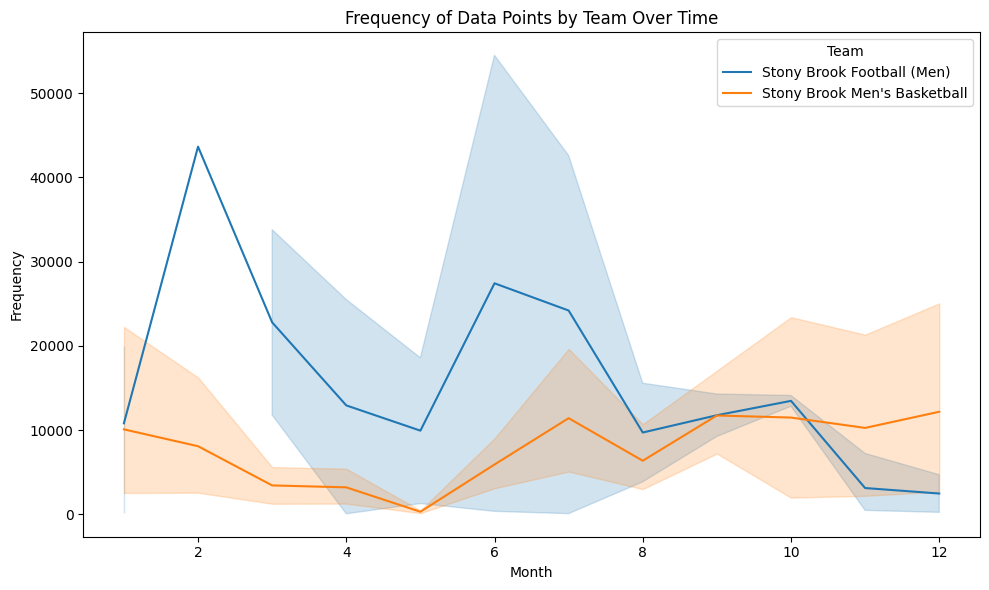

In [30]:
# Testing frequency by team over time
df_teams["timestamp"] = pd.to_datetime(df_teams["timestamp"], errors="coerce")
df_teams["year"] = df_teams["timestamp"].dt.year
df_teams["month"] = df_teams["timestamp"].dt.month

# Create a frequency count by team and month
freq_by_team_month = df_teams.groupby(["team_clean", "year", "month"]).size().reset_index(name="frequency")

# Plotting frequency over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=freq_by_team_month, x="month", y="frequency", hue="team_clean")
plt.title("Frequency of Data Points by Team Over Time")
plt.xlabel("Month")
plt.ylabel("Frequency")
plt.legend(title="Team")
plt.tight_layout()
plt.show()

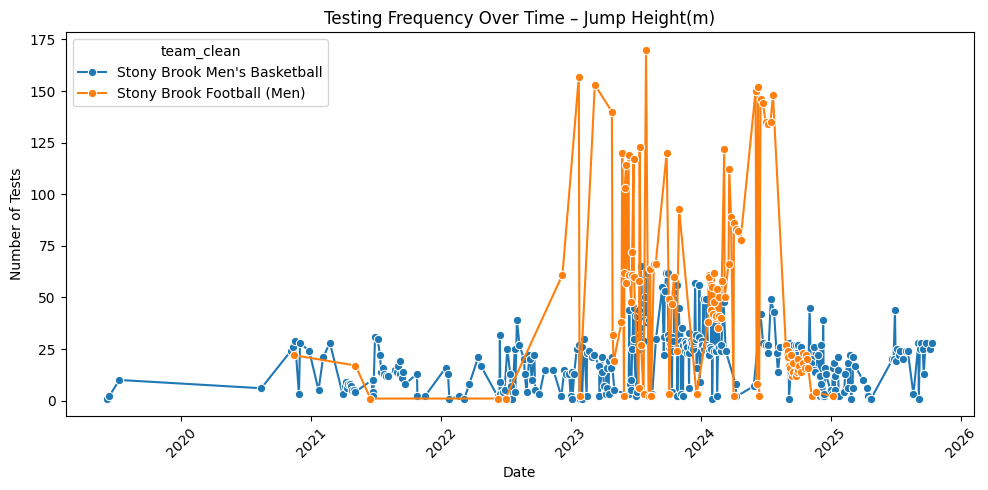

In [ ]:
# Line Plot of Testing Frequency Over Time for Selected Metric
df_freq = (
    df_metric
    .assign(date=df_metric["timestamp"].dt.date)
    .groupby(["date", "team_clean"])
    .size()
    .reset_index(name="num_tests")
)

plt.figure(figsize=(10, 5))
sns.lineplot(
    data=df_freq,
    x="date",
    y="num_tests",
    hue="team_clean",
    marker="o"
)
plt.title(f"Testing Frequency Over Time – {metric}")
plt.xlabel("Date")
plt.ylabel("Number of Tests")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
